# Install & Import

In [ ]:
#import
!pip install pystan fbprophet
!pip install kmodes
import pandas as pd
import gspread
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from sklearn.cluster import KMeans
from sklearn import preprocessing
from oauth2client.client import GoogleCredentials
from google.colab import auth
from fbprophet import Prophet
from fbprophet.plot import plot_seasonality
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from dask.distributed import Client
from kmodes.kprototypes import KPrototypes
from pandas import to_datetime
from sklearn.metrics import mean_squared_error

# Load Data

## Menggunakan GoogleDrive tanpa authentication

In [ ]:
#ambil file dari google drive
df = pd.read_csv('drive/MyDrive/dataset.csv')

## Menggunakan SpreadSheet dengan authentication (recomend)

In [ ]:
#-->authentication untuk spreadsheet
#auth.authenticate_user()
#gc = gspread.authorize(GoogleCredentials.get_application_default())
#worksheet = gc.open('dataset').sheet1

#-->ambil semua data dari spreadsheet
#rows = worksheet.get_all_values()

#-->buat dataframe
#df = pd.DataFrame.from_records(rows)

#==>berhubung pada saat pembuatan dataframe judul kolom menjadi index[0]
#==>maka kita buat judul kolom agar tidak ter-index

#-->buat judul kolom dari index[0]
#df.columns = df.iloc[0]

#-->buat data dari index[1]
#df = df.iloc[1:]

#df.info()

## Menggunakan file import (Recomend karena mudah digunakan)

In [ ]:
#-->ambil dari file import
#df = pd.read_csv('dataset.csv')

# Exploratory Data Analysis (EDA)

## Cek 5 data teratas

In [ ]:
df.head()

,id,delivered_time,brand,outlet,sku,order_quantity
0,1,2021-02-27T16:27:53Z,A,YK28,217,1
1,2,2021-03-01T12:25:19Z,A,YK28,217,1
2,3,2021-03-01T16:02:59Z,A,YK28,217,1
3,4,2021-03-02T12:28:32Z,A,YK28,217,1
4,5,2021-03-03T09:54:11Z,A,YK28,217,1


## Cek 5 data terbawah

In [ ]:
df.tail()

,id,delivered_time,brand,outlet,sku,order_quantity
21332,21333,2022-01-09T21:28:23Z,E,YK28,599,1
21333,21334,2022-01-09T21:33:13Z,C,YK28,994,3
21334,21335,2022-01-09T21:33:13Z,C,YK28,1,1
21335,21336,2022-01-09T21:33:13Z,C,YK28,403,1
21336,21337,2022-01-09T21:33:13Z,C,YK28,899,1


## Cek data penjualan per "order_quantity"

In [ ]:
#versi data
df["order_quantity"].value_counts()

 1     14317
 2      3368
 3      1989
 6       592
 4       578
 5       158
 0        70
 9        60
 12       58
 8        48
-1        24
 7        20
 10       18
 15        7
 18        6
-2         4
-3         4
 20        4
 24        2
 21        2
-4         1
 16        1
 14        1
 28        1
 48        1
 13        1
 30        1
 11        1
Name: order_quantity, dtype: int64

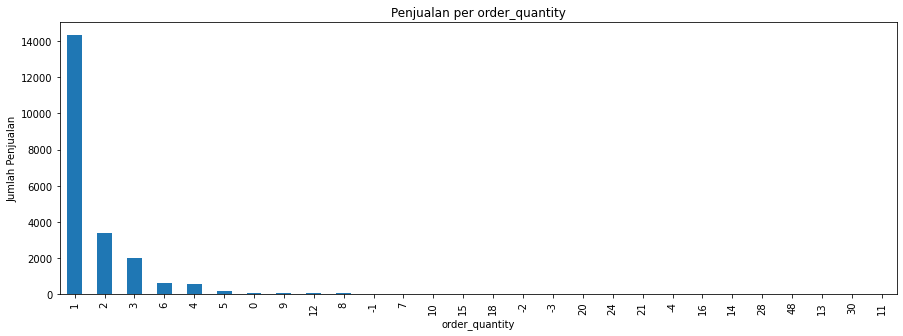

In [ ]:
#versi plot
df["order_quantity"].value_counts().plot(kind="bar", figsize=(15,5), title="Penjualan per order_quantity", xlabel="order_quantity", ylabel="Jumlah Penjualan")

## Cek data penjualan per 'brand' 

In [ ]:
#versi data
df["brand"].value_counts().sort_index()

A      390
B     2292
C    16966
D      423
E      973
F      293
Name: brand, dtype: int64

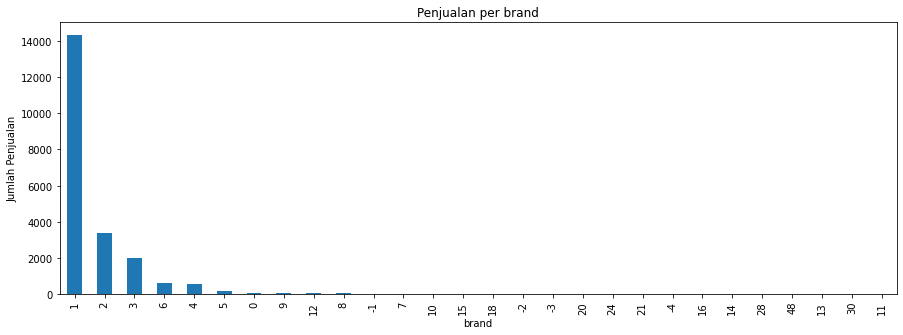

In [ ]:
#versi plot
df["order_quantity"].value_counts().plot(kind="bar", figsize=(15,5), title="Penjualan per brand", xlabel="brand", ylabel="Jumlah Penjualan")

## Cek data penjualan per SKU

In [ ]:
#versi data
df["sku"].value_counts().sort_index()

0       956
1       658
161      41
164      15
165      11
       ... 
995    4160
996    1514
997     572
998    1877
999    1304
Name: sku, Length: 65, dtype: int64

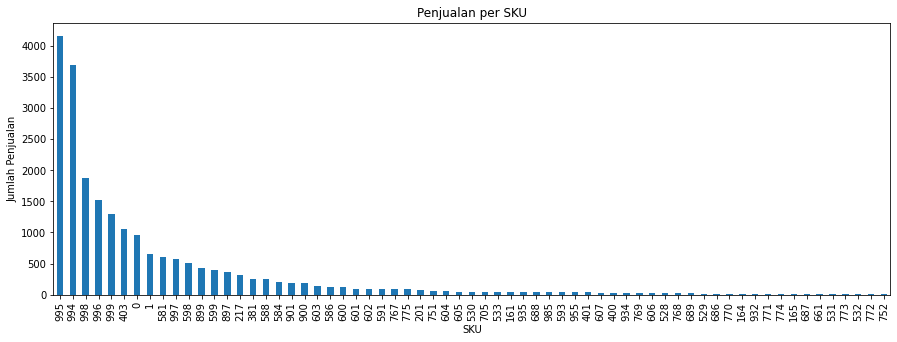

In [ ]:
#versi plot
df["sku"].value_counts().plot(kind="bar", figsize=(15,5), title="Penjualan per SKU", xlabel="SKU", ylabel="Jumlah Penjualan")

## Cek apakah data yang bernilai null?

In [ ]:
df.isna().sum()

id                0
delivered_time    0
brand             0
outlet            0
sku               0
order_quantity    0
dtype: int64

## Cek informasi keseluruhan dari dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21337 entries, 0 to 21336
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              21337 non-null  int64 
 1   delivered_time  21337 non-null  object
 2   brand           21337 non-null  object
 3   outlet          21337 non-null  object
 4   sku             21337 non-null  int64 
 5   order_quantity  21337 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1000.3+ KB


## Cek deskripsi dataframe

In [ ]:
df.describe()

,id,sku,order_quantity
count,21337.000000,21337.000000,21337.000000
mean,10669.000000,797.329381,1.692319
std,6159.605683,311.295269,1.532841
min,1.000000,0.000000,-4.000000
25%,5335.000000,598.000000,1.000000
50%,10669.000000,994.000000,1.000000
75%,16003.000000,995.000000,2.000000
max,21337.000000,999.000000,48.000000


# Preprocessing

In [ ]:
#karena pada saat EDA terdapat data yang (order_quantity < 0), maka data tersebut akan kita drop
df.drop(df[df['order_quantity'] < 0].index, inplace = True)

#ubah format delivered_time menjadi date
df['delivered_time'] = pd.to_datetime(df['delivered_time'].apply(lambda x: str(x)[0:10]))

#reset index
df = df.reset_index(drop=True)

#groupby delivered_time, sku, order_quantity dan hapus kolom id
df = df.groupby(['delivered_time','brand','outlet','sku']).agg({'order_quantity':'sum'}).reset_index()

#display info dataframe terbaru hasil preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049 entries, 0 to 5048
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   delivered_time  5049 non-null   datetime64[ns]
 1   brand           5049 non-null   object        
 2   outlet          5049 non-null   object        
 3   sku             5049 non-null   int64         
 4   order_quantity  5049 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 197.4+ KB


In [ ]:
df

,delivered_time,brand,outlet,sku,order_quantity
0,2021-02-27,A,YK28,217,1
1,2021-03-01,A,YK28,217,2
2,2021-03-02,A,YK28,217,1
3,2021-03-03,A,YK28,217,2
4,2021-03-04,A,YK28,217,2
...,...,...,...,...,...
5044,2022-01-09,E,YK28,599,4
5045,2022-01-09,E,YK28,601,1
5046,2022-01-09,E,YK28,767,1
5047,2022-01-09,E,YK28,775,1


# Clustering

## Clustering semua data penjualan

In [ ]:
#salin dataframe original
df_cluster = df

#buat variable sebelum mengubah order_quantity menjadi float
mark_array=df_cluster.values

#ubah tipe data order_quantity menjadi float
mark_array[:, 4] = mark_array[:, 4].astype(float)

#buat model
kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=20)
#fit model
clusters = kproto.fit_predict(mark_array, categorical=[0,1,2,3])

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 858, ncost: 339532.54415791016
Run: 1, iteration: 2/20, moves: 289, ncost: 285348.4928820885
Run: 1, iteration: 3/20, moves: 80, ncost: 277741.180851823
Run: 1, iteration: 4/20, moves: 10, ncost: 277579.8181664991
Run: 1, iteration: 5/20, moves: 0, ncost: 277579.8181664991
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 662, ncost: 321688.44623673626
Run: 2, iteration: 2/20, moves: 222, ncost: 282747.89341350633
Run: 2, iteration: 3/20, moves: 66, ncost: 277620.9936037157
Run: 2, iteration: 4/20, moves: 5, ncost: 277579.8181664991
Run: 2, iteration: 5/20, moves: 0, ncost: 277579.8181664991
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/20, moves: 564, ncost: 312280.73919228977
Run: 3, iteration: 2/20, mo

In [ ]:
#display centroid
print(kproto.cluster_centroids_)

[[4.3655230834392205 Timestamp('2022-01-05 00:00:00') 'C' 'YK28' 581]
 [47.53211009174312 Timestamp('2021-08-24 00:00:00') 'C' 'YK28' 995]]


In [ ]:
#buat variable array untuk menampung cluster dari setiap data
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)

#display
cluster_dict

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
#buat kolom baru untuk disisipkan data cluster
df_cluster['cluster']=cluster_dict
#display
df_cluster

,delivered_time,brand,outlet,sku,order_quantity,cluster
0,2021-02-27,A,YK28,217,1,0
1,2021-03-01,A,YK28,217,2,0
2,2021-03-02,A,YK28,217,1,0
3,2021-03-03,A,YK28,217,2,0
4,2021-03-04,A,YK28,217,2,0
...,...,...,...,...,...,...
5044,2022-01-09,E,YK28,599,4,0
5045,2022-01-09,E,YK28,601,1,0
5046,2022-01-09,E,YK28,767,1,0
5047,2022-01-09,E,YK28,775,1,0


## Clustering data penjualan brand di outlet YK28

In [ ]:
#salin dataframe original
df_cluster2 = df

#menghapus kolom id
df_cluster2 = df_cluster2.drop(["delivered_time", "sku"], axis=1)

#buat variable sebelum mengubah order_quantity menjadi float
mark_array=df_cluster2.values

#ubah tipe data order_quantity menjadi float
mark_array[:, 2] = mark_array[:, 2].astype(float)

#buat model
kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=20)

#fit model
clusters = kproto.fit_predict(mark_array, categorical=[0,1])

#buat cluster dictionary
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)

#buat kolom baru untuk disisipkan cluster dictionary
df_cluster2['cluster']=cluster_dict

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 472, ncost: 241807.55491062056
Run: 1, iteration: 2/20, moves: 156, ncost: 217403.95045220206
Run: 1, iteration: 3/20, moves: 50, ncost: 214247.6596720691
Run: 1, iteration: 4/20, moves: 2, ncost: 214241.15153093153
Run: 1, iteration: 5/20, moves: 0, ncost: 214241.15153093153
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 267, ncost: 223551.70752463103
Run: 2, iteration: 2/20, moves: 90, ncost: 214436.33799347977
Run: 2, iteration: 3/20, moves: 11, ncost: 214241.15153093153
Run: 2, iteration: 4/20, moves: 0, ncost: 214241.15153093153
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/20, moves: 231, ncost: 221012.68968802388
Run: 3, iteration: 2/20, moves: 74, ncost: 214371.14582533317
Run: 3, iteration: 3/20, moves: 9, ncost: 214241.15153093153
Run: 3, iteration

In [ ]:
#display
df_cluster2

,brand,outlet,order_quantity,cluster
0,A,YK28,1,1
1,A,YK28,2,1
2,A,YK28,1,1
3,A,YK28,2,1
4,A,YK28,2,1
...,...,...,...,...
5044,E,YK28,4,1
5045,E,YK28,1,1
5046,E,YK28,1,1
5047,E,YK28,1,1


## Clustering data penjualan brand & sku di outlet YK28

In [ ]:
#salin dataframe original
df_cluster3 = df

#menghapus kolom id
df_cluster3 = df_cluster3.drop(["delivered_time"], axis=1)

#buat variable sebelum mengubah order_quantity menjadi float
mark_array=df_cluster3.values

#ubah tipe data order_quantity menjadi float
mark_array[:, 3] = mark_array[:, 3].astype(float)

#buat model
kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=20)

#fit model
clusters = kproto.fit_predict(mark_array, categorical=[0,1,2])

#buat cluster dictionary
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)

#buat kolom baru untuk disisipkan cluster dictionary
df_cluster3['cluster']=cluster_dict

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 663, ncost: 280078.3388378229
Run: 1, iteration: 2/20, moves: 220, ncost: 241379.9714454433
Run: 1, iteration: 3/20, moves: 67, ncost: 236203.8638932664
Run: 1, iteration: 4/20, moves: 4, ncost: 236177.62016984832
Run: 1, iteration: 5/20, moves: 0, ncost: 236177.62016984832
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 77, ncost: 237135.58744883278
Run: 2, iteration: 2/20, moves: 25, ncost: 236177.62016984832
Run: 2, iteration: 3/20, moves: 0, ncost: 236177.62016984832
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/20, moves: 357, ncost: 250414.550902552
Run: 3, iteration: 2/20, moves: 104, ncost: 237388.9421137733
Run: 3, iteration: 3/20, moves:

In [ ]:
#display
df_cluster3

,brand,outlet,sku,order_quantity,cluster
0,A,YK28,217,1,1
1,A,YK28,217,2,1
2,A,YK28,217,1,1
3,A,YK28,217,2,1
4,A,YK28,217,2,1
...,...,...,...,...,...
5044,E,YK28,599,4,1
5045,E,YK28,601,1,1
5046,E,YK28,767,1,1
5047,E,YK28,775,1,1


# Forecasting

In [ ]:
def model_forecast(no_sku):
  #set data untuk data training & valid 
  X_train = df[df['delivered_time'] < '2021-12-27']
  X_valid = df[df['delivered_time'] >= '2021-12-27']

  #filter data training dengan sku
  train = X_train[X_train['sku'] == no_sku]
  train2 = train[['delivered_time', 'order_quantity']]

  #filter data validation dengan sku==1
  valid = X_valid[X_valid['sku'] == no_sku]
  valid2 = valid[['delivered_time', 'order_quantity']]

  #set index menjadi date
  train2.set_index('delivered_time', inplace=True)
  valid2.set_index('delivered_time', inplace=True)

  #buat variable untuk menampung berapa jumlah data valid
  total = len(valid.index)

  #buat variable untuk memprediksi
  index_14_days = pd.date_range(valid2.index[0], freq='D', periods=total)

  #set data yang akan dilakukan forecast
  train3 = train.copy()
  train3 = train3[['delivered_time', 'order_quantity']]
  train3.columns = ['ds', 'y']

  #buat model
  model = Prophet()

  #fit model
  model.fit(train3)

  #definisikan periode untuk prediksi
  df_index_14_days = pd.DataFrame(index_14_days)
  df_index_14_days.columns = ['ds']
  df_index_14_days['ds'] = to_datetime(df_index_14_days['ds'])

  #gunakan model untuk forecasting
  fcast3 = model.predict(df_index_14_days)
  fcast3 = pd.Series(fcast3['yhat'].values, index=index_14_days)
  fcast3 = fcast3.rename('Prophet')

  #buat plot
  fig, ax = plt.subplots(figsize=(15,5))
  chart = sns.lineplot(x='delivered_time', y='order_quantity', data=train)
  chart.set_title('Forecasting Chart')
  fcast3.plot(ax=ax, color='red', marker='o', legend=True)
  valid2.plot(ax=ax, color='blue', marker='o', legend=True)

  #tampilkan MSE
  print('MSE FBProphet:', mean_squared_error(valid['order_quantity'].values, fcast3.values, squared=False))

Silahkan input Nomor SKU:
1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting dengan SKU: 1
MSE FBProphet: 2.817028689411631


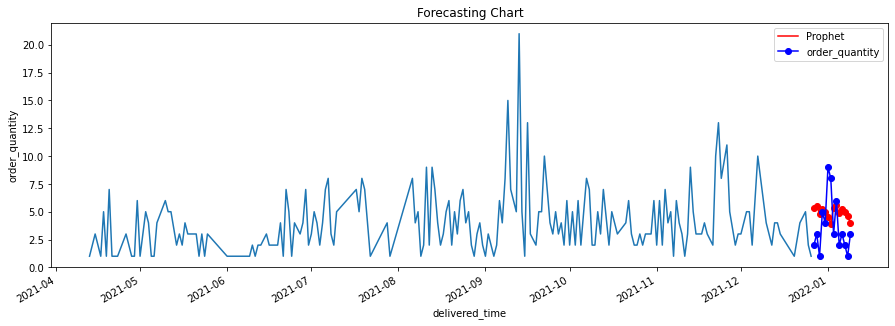

In [ ]:
print('Silahkan input Nomor SKU:')
no_sku = input()
print('Forecasting dengan SKU: ' + no_sku)
no_sku = int(no_sku)
if no_sku in df['sku'].values:
  model_forecast(no_sku)
else:
  print("Nomor SKU tidak ada")

In [ ]:
#get list sku
data_sku = df
data_sku = data_sku.drop_duplicates('sku').sort_values(by=['sku']).reset_index()
data_sku.drop(['index', 'delivered_time', 'brand', 'outlet', 'order_quantity', 'cluster'], axis=1, inplace=True)
data_sku
len(data_sku)

65